In [2]:
import numpy as np
import pyedflib
from matplotlib import pyplot as plt
from pyedflib import highlevel, EdfReader

from config import Paths, Durations, Constants
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

from utils.edf_utils import index_to_time, time_to_index

# Idealized case
In the ideal case, there would be a single file that contains the whole preictal interval.
In reality, the interval is not always fully contained, it can be split between files, and these files might have a break in between them.
→ It's necessary to see which portions of the preictal interval are contained or only use seizures where the entire interval is contained.


In [3]:
# load seizure annotation
patient_dir = Paths.FOR_MAYO_DIR / 'B52K3P3G'
seizure_annotation_file = Paths.seizure_annotations_dir(patient_dir) / 'B52K3P3G_CONSENSUS_corrected.csv.csv'
seizure_annotations = pd.read_csv(seizure_annotation_file, parse_dates=['start', 'end', 'single_marker'])
seizure_annotations

,type,start,single_marker,end,comment
0,Seizure-rhythmic,NaT,2021-10-08 12:45:01.725,NaT,Start V5a
1,Seizure-rhythmic,NaT,2021-10-08 15:40:12.692,NaT,NaN
2,Seizure-rhythmic,NaT,2021-10-08 18:20:23.968,NaT,NaN
3,Seizure-rhythmic,NaT,2021-10-08 20:20:26.020,NaT,NaN
4,Seizure-rhythmic,NaT,2021-10-08 20:22:15.530,NaT,NaN
...,...,...,...,...,...
2309,Seizure-rhythmic,NaT,2022-03-19 21:17:06.608,NaT,NaN
2310,Seizure-rhythmic,NaT,2022-04-03 12:45:20.173,NaT,NaN
2311,Seizure-rhythmic,NaT,2022-04-03 16:27:33.287,NaT,NaN
2312,Seizure-rhythmic,NaT,2022-04-03 18:26:30.035,NaT,NaN


In [4]:
# szr_nr = 1  # A seizure where the preictal interval is fully contained in a file
szr_nr = 3  # A seizure where the preictal interval spans 2 files
seizure = seizure_annotations.loc[szr_nr]
szr_time = seizure['single_marker']
szr_time

Timestamp('2021-10-08 20:20:26.020000')

In [5]:
preictal_end = szr_time - Durations.PREICTAL_OFFSET
preictal_end

Timestamp('2021-10-08 20:15:26.065000')

In [6]:
preictal_start = szr_time - Durations.PREICTAL_INTERVAL
preictal_start

Timestamp('2021-10-08 19:20:26.560000')

In [7]:
# load the edf files list
edf_files_path = Paths.edf_files_sheet(patient_dir)
edf_files = pd.read_csv(edf_files_path, parse_dates=['start', 'end'])
# edf_files

In [8]:
# find the edf file(s) that contain(s) the interval
# Find files that have any overlap with the preictal interval
# the formula a_start <= b_end and b_start <= a_end determines overlap between any intervals a and b
overlapping_interval_mask = (preictal_start <= edf_files['end']) & (edf_files['start'] <= preictal_end)
matching_edfs = edf_files[overlapping_interval_mask]
matching_edfs

,old_file_name,file_name,start,end,duration_hours,visit
1,B52K3P3G_02_0004245_20211008_02_EEGdata.edf,B52K3P3G_2021-10-08_18-32-22.edf,2021-10-08 18:32:22,2021-10-08 19:40:00.391150,1:07:38.391150,5a
2,B52K3P3G_02_0004245_20211008_03_EEGdata.edf,B52K3P3G_2021-10-08_19-58-02.edf,2021-10-08 19:58:02,2021-10-08 21:33:38.139450,1:35:36.139450,5a


In [9]:
# Find the file that contains the seizure (probably not needed in practice)
_szr_file = edf_files[(edf_files['start'] <= szr_time) & (szr_time <= edf_files['end'])]

In [10]:
# load the edf file
preictal_edf_info = matching_edfs.iloc[0]
preictal_edf_path = Paths.edf_dir(patient_dir) / preictal_edf_info['file_name']
# todo error handling for IO (use with / try)
preictal_edf = EdfReader(str(preictal_edf_path))

In [11]:
# convert the preictal end to index and select the correct slice based on that
preictal_end_idx = round(time_to_index(preictal_edf.getStartdatetime(), preictal_end, Constants.SAMPLING_FREQUENCY_HZ))
preictal_end_idx

1280293

In [12]:
preictal_start_idx = preictal_end_idx - Durations.PREICTAL_INTERVAL_N_SAMPLES
preictal_start_idx

535093

In [13]:
# load preictal interval
N_CHANNELS = preictal_edf.signals_in_file
preictal_signals = np.zeros((N_CHANNELS, Durations.PREICTAL_INTERVAL_N_SAMPLES))
for channel in range(N_CHANNELS):
    preictal_signals[channel, :] = preictal_edf.readSignal(
        chn=channel,
        start=preictal_start_idx,
        n=Durations.PREICTAL_INTERVAL_N_SAMPLES)
preictal_signals.shape

read 305120, less than 745200 requested!!!
read 305120, less than 745200 requested!!!


(2, 745200)

In [14]:
preictal_edf.close()

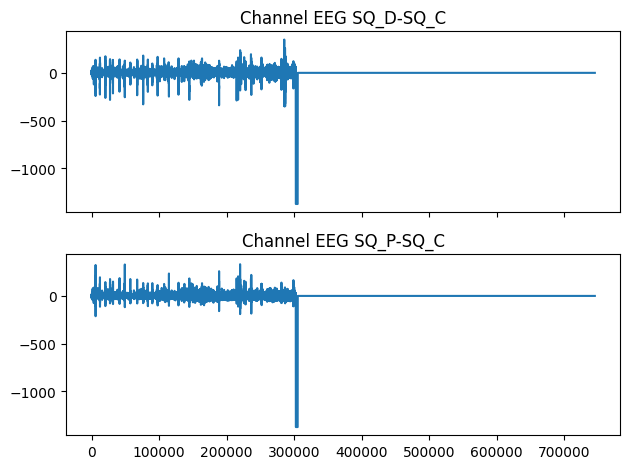

In [15]:
# plot the preictal_signals
preictal_header = pyedflib.highlevel.read_edf_header(str(preictal_edf_path))
fig, ax = plt.subplots(nrows=N_CHANNELS, sharex=True, sharey=True,
                       # figsize=(10, 10)
                       )
for channel in range(N_CHANNELS):
    ax[channel].plot(preictal_signals[channel, :])
    channel_name = preictal_header['SignalHeaders'][channel]['label']
    ax[channel].set_title(f'Channel {channel_name}')
plt.tight_layout()

In [16]:
clips = preictal_signals.reshape((-1, N_CHANNELS, Durations.CLIP_N_SAMPLES))
clips.shape

(6, 2, 124200)

In [17]:
Durations.CLIP_N_SAMPLES

124200

In [18]:
segments = clips.reshape((clips.shape[0], -1, N_CHANNELS, Durations.SEGMENT_N_SAMPLES))
segments.shape

(6, 40, 2, 3105)

# Split Files case

In [19]:
matching_edfs

,old_file_name,file_name,start,end,duration_hours,visit
1,B52K3P3G_02_0004245_20211008_02_EEGdata.edf,B52K3P3G_2021-10-08_18-32-22.edf,2021-10-08 18:32:22,2021-10-08 19:40:00.391150,1:07:38.391150,5a
2,B52K3P3G_02_0004245_20211008_03_EEGdata.edf,B52K3P3G_2021-10-08_19-58-02.edf,2021-10-08 19:58:02,2021-10-08 21:33:38.139450,1:35:36.139450,5a


In [20]:
# NOTE: we only use segments that were fully recorded in the edf file
# NOTE: this could be sped up a lot if the matching edfs were just accessed and the data was directly reshaped into the segments

# This will store whether a segment is contained the data or not
# segment_starts = {preictal_start + i * Durations.SEGMENT : None for i in range(segments_per_preictal_interval)}
segments = np.zeros((Durations.SEGMENTS_PER_PREICTAL_INTERVAL, N_CHANNELS, Durations.SEGMENT_N_SAMPLES))
segment_ranges = []

for i in range(Durations.SEGMENTS_PER_PREICTAL_INTERVAL):
    start = preictal_start + i * Durations.SEGMENT
    end = start + Durations.SEGMENT
    segment_ranges.append((start, end))

    # Find the edf that fully contains the segment (if any)
    segment_edf = matching_edfs[(matching_edfs['start'] <= start) & (end <= matching_edfs['end'])]

    # load the data if it exists
    if len(segment_edf) > 0:
        edf_path = Paths.edf_dir(patient_dir) / segment_edf['file_name'].item()
        edf = EdfReader(str(edf_path))

        # todo not sure if this is correct -> the next segment could share the end of this one because of rounding
        start_idx = round(time_to_index(edf.getStartdatetime(), start, Constants.SAMPLING_FREQUENCY_HZ))

        for channel in range(N_CHANNELS):
            segments[i, channel, :] = edf.readSignal(chn=channel, start=start_idx, n=Durations.SEGMENT_N_SAMPLES)

        edf.close()

# for idx, edf in matching_edfs.iterrows():
# edf_path = Paths.edf_dir(patient_dir) / edf['file_name']
# signals, signal_headers, header = highlevel.read_edf(str(edf_path))



In [21]:
start_idx

275149

In [22]:
print(f'{segments.shape=}')
segment_num = 144

segments.shape=(240, 2, 3105)


segment_num=144
start: 2021-10-08 19:56:26.236000
end  : 2021-10-08 19:56:41.233750


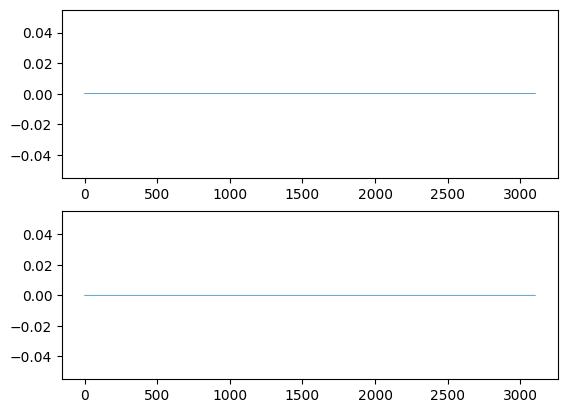

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
print(f'{segment_num=}')
print(f'start: {segment_ranges[segment_num][0]}')
print(f'end  : {segment_ranges[segment_num][1]}')
ax1.plot(segments[segment_num, 0, :], linewidth=0.5)
ax2.plot(segments[segment_num, 1, :], linewidth=0.5)
segment_num += 1

In [26]:
# Table of Segments
index = pd.MultiIndex.from_product([range(Durations.CLIPS_PER_PREICTAL_INTERVAL), range(Durations.SEGMENTS_PER_CLIP)],
                                   names=['clip', 'segment'])
segments = pd.DataFrame(index=index, columns=['start', 'end', 'exists', 'file', 'start_index'])

segments['start'] = preictal_start + segments.index.get_level_values(
    0) * Durations.CLIP + segments.index.get_level_values(1) * Durations.SEGMENT
segments['end'] = segments['start'] + Durations.SEGMENT

segments['exists'] = False
for edf in matching_edfs.iterrows():
    print(edf)
    # Set the property "exists" to True for all segments contained in the edf
    segments_contained_in_edf = edf['start'] <= segments['start'] & segments['end'] <= edf['end']
    segments[segments_contained_in_edf]['exists'] = True
    segments[segments_contained_in_edf]['file'] = edf['file_name']

# matching_edfs['start'] <= segments['start']
# matching_check = matching_edfs[(matching_edfs['start'] <= segments['start']) & (segments['end'] <= matching_edfs['end'])]
# segments['exists'] = len(matching_check) > 0


# for clip_idx in range(Durations.CLIPS_PER_PREICTAL_INTERVAL):
#     for segment_idx in range(Durations.SEGMENTS_PER_CLIP):
#         start = preictal_start + clip_idx * Durations.CLIP + segment_idx * Durations.SEGMENT
#         end = start + Durations.SEGMENT
#
#         # Find the edf that fully contains the segment (if any)
#         segment_edfs = matching_edfs[(matching_edfs['start'] <= start) & (end <= matching_edfs['end'])]
#         assert len(segment_edfs) <= 1, f"Multiple matches for segment: {start} - {end}"
#         edf_exists = len(segment_edfs) == 1
#
#         file_name = None
#         start_idx = None
#         if edf_exists:
#             segment_edf = segment_edfs.item()
#
#             file_name = segment_edf['file_name'].item()
#             edf_path = Paths.edf_dir(patient_dir) / file_name
#             edf = EdfReader(str(edf_path))
#             start_idx = time_to_index(edf.getStartdatetime(), start, Constants.SAMPLING_FREQUENCY_HZ)
#
#         segments.loc[clip_idx, segment_idx] = [start, end, edf_exists, file_name, start_idx]
#
#
#


# # This will store whether a segment is contained the data or not
# # segment_starts = {preictal_start + i * Durations.SEGMENT : None for i in range(segments_per_preictal_interval)}
# segments = np.zeros((Durations.SEGMENTS_PER_PREICTAL_INTERVAL, N_CHANNELS, Durations.SEGMENT_N_SAMPLES))
# segment_ranges = []
# #
# for i in range(Durations.SEGMENTS_PER_PREICTAL_INTERVAL):
#     start = preictal_start + i * Durations.SEGMENT
#     end = start + Durations.SEGMENT
#     segment_ranges.append((start, end))
#
#     # Find the edf that fully contains the segment (if any)
#     segment_edf = matching_edfs[(matching_edfs['start'] <= start) & (end <= matching_edfs['end'])]
#
#     # load the data if it exists
#     if len(segment_edf) > 0:
#         edf_path = Paths.edf_dir(patient_dir) / segment_edf['file_name'].item()
#         edf = EdfReader(str(edf_path))
#
#         start_idx = time_to_index(edf.getStartdatetime(), start, Constants.SAMPLING_FREQUENCY_HZ)
#
#         for channel in range(N_CHANNELS):
#             segments[i, channel, :] = edf.readSignal(chn=channel, start=start_idx, n=Durations.SEGMENT_N_SAMPLES)
#
#         edf.close()

# for idx, edf in matching_edfs.iterrows():
# edf_path = Paths.edf_dir(patient_dir) / edf['file_name']
# signals, signal_headers, header = highlevel.read_edf(str(edf_path))



(1, old_file_name     B52K3P3G_02_0004245_20211008_02_EEGdata.edf
file_name                    B52K3P3G_2021-10-08_18-32-22.edf
start                                     2021-10-08 18:32:22
end                                2021-10-08 19:40:00.391150
duration_hours                                 1:07:38.391150
visit                                                      5a
Name: 1, dtype: object)


TypeError: tuple indices must be integers or slices, not str

In [123]:
segments

start                        end exists  \
clip segment                                                                
0    0       2021-10-08 19:20:26.560000 2021-10-08 19:20:41.557750    NaN   
     1       2021-10-08 19:20:41.557750 2021-10-08 19:20:56.555500    NaN   
     2       2021-10-08 19:20:56.555500 2021-10-08 19:21:11.553250    NaN   
     3       2021-10-08 19:21:11.553250 2021-10-08 19:21:26.551000    NaN   
     4       2021-10-08 19:21:26.551000 2021-10-08 19:21:41.548750    NaN   
...                                 ...                        ...    ...   
5    35      2021-10-08 20:19:11.031250 2021-10-08 20:19:26.029000    NaN   
     36      2021-10-08 20:19:26.029000 2021-10-08 20:19:41.026750    NaN   
     37      2021-10-08 20:19:41.026750 2021-10-08 20:19:56.024500    NaN   
     38      2021-10-08 20:19:56.024500 2021-10-08 20:20:11.022250    NaN   
     39      2021-10-08 20:20:11.022250 2021-10-08 20:20:26.020000    NaN   

             file start_index  
clip segment                   
0    0        NaN         NaN  
     1        NaN         NaN  
     2        NaN         NaN  
     3        NaN         NaN  
     4        NaN         NaN  
...           ...         ...  
5    35       NaN         NaN  
     36       NaN         NaN  
     37       NaN         NaN  
     38       NaN         NaN  
     39       NaN         NaN  

[240 rows x 5 columns]